## Projekt Modelowanie układów przepływowych
### Jak zmienia się amplituda fali uderzającej w pionowe nabrzeże w zależności od wysokości trapezoidalnej przeszkody?
##### Szymon Słotwiński FT rok 4 gr. 1

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
NUMBH_THREADING_LAYER = 'omp'
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

### 1. Opis układu

Według JBA Trust, autorów filmu “Wave tank demonstration showing the impact of coastal defences on flood risk”, jedną z najskuteczniejszych form ochrony wybrzeża jest trapezoidalna przeszkoda ustawiona kilka metrów przed nabrzeżem. Poglądowy rysunek analizowanego przez mnie układu przedstawiony jest poniżej.

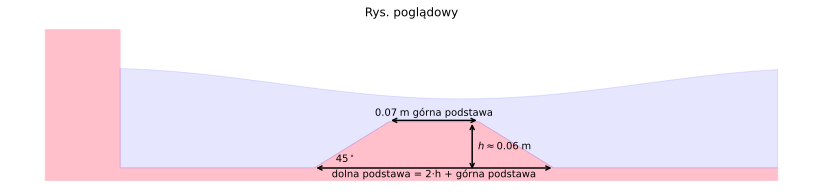

In [ ]:
plt.figure(figsize=(14.5,3))
plt.axis('off')

x = np.linspace(-np.pi, np.pi)
z = np.sin(x-2)/2+.25

b = x/x-3.5
idx = 27
b[idx-8:idx-3] = b[idx-8:idx-3] + np.linspace(1, 5, 5)*0.3
b[idx-3:idx+3] = b[idx-4]
b[idx+3:idx+8] = b[idx-4] - np.linspace(1, 5, 5)*0.3
bwall = b[:6].copy()
bwall[:] = 2

arrow_kwargs = {'length_includes_head': True, 'head_width': .05}

ix = 5; color='pink'; label='$b$'
plt.fill_between(x[5:], b[5:], -2.9, color=color, label=f'$z=-${label}')
plt.fill_between(x[:6], bwall, -2.9, color=color)

ix = 10; color='blue'; label=r'$\zeta$'
plt.fill_between(x[5:], z[5:], b[5:], color=color, label=f'$z=${label}', alpha=.1)

x_h = x[idx] + 0.2
y_bottom = -2.6
y_top = b[idx]

plt.annotate(
    "", xy=(x_h, y_top), xytext=(x_h, y_bottom),
    arrowprops=dict(arrowstyle="<->", color="black", lw=1.5)
)
plt.text(
    x_h + 0.05, (y_top + y_bottom)/2,
    r"$h \approx 0.06\;\mathrm{m}$",
    va="center"
)

x1_top = x[idx-4]
x2_top = x[idx+2]
y_top_base = b[idx] + 0.05

plt.annotate(
    "", xy=(x1_top, y_top_base), xytext=(x2_top, y_top_base),
    arrowprops=dict(arrowstyle="<->", color="black", lw=1.5)
)
plt.text(
    (x1_top + x2_top)/2,
    y_top_base + 0.15,
    r"$0.07\;\mathrm{m}$ górna podstawa",
    ha="center"
)

x1_bottom = x[idx-9]
x2_bottom = x[idx+7]
y_bottom_base = -2.5

plt.annotate(
    "", xy=(x1_bottom, y_bottom_base), xytext=(x2_bottom, y_bottom_base),
    arrowprops=dict(arrowstyle="<->", color="black", lw=1.5)
)
plt.text(
    (x1_bottom + x2_bottom)/2,
    y_bottom_base - 0.3,
    r"dolna podstawa = 2$\cdot$h + górna podstawa",
    ha="center"
)


plt.text(
    -0.65, -2.3,
    r"$45^\circ$",
    color="black"
)

plt.title("Rys. poglądowy")
show_plot('symbols.pdf')
plt.show()

Na rysunku powyżej widoczny jest układ. Po lewej stronie znajduje się pionowe nabrzeże, natomiast w centralnej części umieszczona jest badana przeszkoda. Celem projektu jest zbadanie, w jaki sposób geometria przeszkody wpływa na amplitudę fali docierającej do nabrzeża. Nabrzeże modelujemy jako pionową ścianę jako zamknięty warunek brzegowy dla $y = 0$.

W filmie wykorzystano akwarium o wymiarach $1.5 \times 0.2 \times 0.4\,\mathrm{m}$ (zgodnie z danymi technicznymi JBA Trust). Ze względu na symetrię układu względem osi $x$ interesuje nas najbardziej zachowanie wzdłuż osi $y$. Dlatego siatka, którą używam będzie wzdłuż osi y bardziej gęststa.

Przeszkoda w eksperymencie została ustawiona w pobliżu środka zbiornika. Akwarium wypełnione było około 25 litrami wody, co odpowiada wysokości początkowej $h = 0.0833\,\mathrm{m}$. Dokładne wymiary przeszkody nie zostały podane, dlatego oszacowałem, że jej wysokość wynosi około $0.06\,\mathrm{m}$, natomiast szerokość górnej podstawy $0.07\,\mathrm{m}$. Dodatkowo określiłem, że kąt nachylenia zboczy przeszkody ma wartość około $45^\circ$.

Poniższa funkcja make_bathymery tworzy geometrię bathymetrii. Przyjmuje wymiary siatki, wysokość początkową $h$ oraz pozostałe parametry, na podstawie których generuje profil przeszkody. Przeszkoda jest skalowana tak, aby zachować jej pierwotny kształt, w szczególności stały kąt nachylenia zboczy. Parametr y_len określa rzeczywistą długość akwarium w metrach, wm jest szerokością górnej podstawy przeszkody, natomiast opcjonalny parametr w_podst pozwala na ręczne ustawienie szerokości dolnej podstawy. Domyślnie jest ona wyznaczana jako $2h$ (wynikające z kąta $45^\circ$) powiększone o szerokość górnej podstawy.

In [4]:
def make_bathymery(grid: tuple, h: float, y_len: float = 1.5, wm: float = 0.07, w_podst: int = None):
    bathymetry = np.zeros(grid)
    w = int(wm*grid[1]/y_len)
    hg = int(h*grid[1]/y_len)
    if w_podst is None:
      w_podst = 2*hg + w
    nx, ny = grid
    s = ny//2

    if s - w_podst < 0 or s + w_podst >= ny:
        print("Przeszkoda wychodzi poza siatkę!")

    b = np.zeros(ny)

    # LEWE ZBOCZE
    b[s - w_podst : s - w] = np.linspace(0, h, w_podst-w)
    # GÓRNA PODSTAWA
    b[s - w : s + w] = h
    # PRAWE ZBOCZE
    b[s + w : s + w_podst] = np.linspace(h, 0, w_podst-w)

    bathymetry[:, :] = b

    return bathymetry


Jako warunek początkowy przyjąłem stałą powierzchnię o wartości 0.0833m względem dna, oraz na brzegu nadałem falę o kształcie funkcji Gaussa ze środkiem na brzegu siatki. Poniższa funkcja generuje falę początkową na podstawie przekazanej wielkości siatki. Parametry fali jak A, sigmam oszacowałem ponownie z filmu. Ich wartości to A=0.02m oraz sigmam=0.06m.

In [5]:
def make_gauss_init(grid: tuple, A: float = 0.02, sigmam: float = 0.06, y_len: float = 1.5):
  sigma = int(sigmam*grid[1]/y_len)
  nx, ny = grid
  y = np.arange(ny)
  x = np.arange(nx)
  X, Y = np.meshgrid(x, y, indexing="ij")
  gauss = A * np.exp(-((Y - ny)**2) / (2 * sigma**2))
  return gauss

In [6]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, bathymetry: np.ndarray,
                 uh_initial: np.ndarray = None, vh_initial: np.ndarray = None,
                 options: Options = None):
        """ initializes the solvers for a given initial condition """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        self.bathymetry = bathymetry

        if uh_initial is None:
            uh_initial = np.zeros(grid)
        if vh_initial is None:
            vh_initial = np.zeros(grid)

        stepper = Stepper(options=options, grid=grid, n_threads=1)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }

        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_initial, **kwargs),
            "vh": ScalarField(vh_initial, **kwargs),
        }

        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()

    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None)
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[(
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        if np.amax(np.abs(courant_number)) > 1:
          print(np.amax(np.abs(courant_number)))
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1):
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

### 2. Symulacja i analiza zbieżności

In [7]:
def make_sym(grid: tuple, h: float, nt: int = 1200, dt_over_dxy: tuple = (.7, .25), surface_level: float = 0.0833, outfreq: int = 1):
  gauss = make_gauss_init(grid)
  bathymetry = make_bathymery(grid, h = h)
  bathymetry = surface_level - bathymetry

  h_initial = bathymetry.copy()
  h_initial +=  gauss
  output = ShallowWaterEquationsIntegrator(
  h_initial=h_initial,
  bathymetry=bathymetry
  )(
      nt=nt, g=10, dt_over_dxy=dt_over_dxy, outfreq=outfreq
  )
  global_max_y0 = max(np.max(frame[:, 0]) for frame in output['h'])

  return global_max_y0 - surface_level, output["h"]

Jako podstawową siatkę symulacyjną przyjąłem grid = (6, 200), ponieważ interesuje nas przede wszystkim propagacja fali wzdłuż kierunku *y*. Z tego powodu siatkę wzdłuż osi *y* podzieliłem na 200 węzłów, co odpowiada rzeczywistej odległości między węzłami:

$$ \frac{1.5\ \text{m}}{200} = 0.75\ \text{cm}. $$

Wysokość przeszkody zmieniałem w zakresie od 0 do 0.073 m. Dalsze zwiększanie wysokości często prowadziło do problemów ze stabilnością symulacji. Próbowałem temu zaradzić, zmieniając parametr $\frac{\Delta t}{\Delta y}$, jednak dla stosunkowo niewielkiego wzrostu, np. przy $h = 0.075\ \text{m}$, wartość zapewniająca stabilność musiała wynosić aż:

$$ \frac{\Delta t}{\Delta y} = 0.01, $$

co prowadziło do znacznego wydłużenia czasu trwania symulacji.


In [ ]:
grid = (6, 200)
hs = np.linspace(0, 0.073, 15)
hend = np.zeros_like(hs)
for i, h in enumerate(hs):
  hend[i], output_h = make_sym(grid=grid, h=h)

Na poniższym wykresie przedstawione są przekroje powierzchni wody dla wybranych kroków czasowych symulacji. Oś batymetrii (przerywana czarna linia) znajduje się po prawej stronie.

Dla kroku $t / \Delta t = 200 $ widoczna jest fala zbliżająca się do przeszkody. Jej czoło ulega spowolnieniu, co wynika z lokalnego zmniejszenia głębokości i odpowiadającego mu spadku prędkości propagacji fali, która jest proporcjonalna do głębokości.

W kroku $t / \Delta t = 400$ fala znajduje się nad przeszkodą. W tym obszarze część fali jest transmitowana dalej, natomiast część ulega odbiciu. Zastanawiające jest jednak to, dlaczego fala dzieli się tutaj na dwie odseparowane części. Może to wynikać z niedostatecznej dokładności siatki albo z faktu, że funkcję początkową Gaussa można rozpisać na sumę fal sinusoidalnych z transformaty Fouriera. Ze względu na relację dyspersji, poszczególne składowe mogą przemieszczać się z różną prędkością, rozrywając kształt fali. Prawdopodobnie jest to jednak efekt niefizyczny.

Dla kroku $t / \Delta t = 700 $ widoczna jest fala odbita przemieszczająca się w stronę brzegu początkowego. Za przeszkodą natomiast fala rozdziela się na dwa fronty propagacji o różnych amplitudach, co jest wynikiem przejścia fali przez obszar podwyższonego dna. Na szczycie przeszkody obserwujemy również lokalne obniżenie powierzchni wody, związane z obniżoną prędkością i zmianą strumienia przepływu.


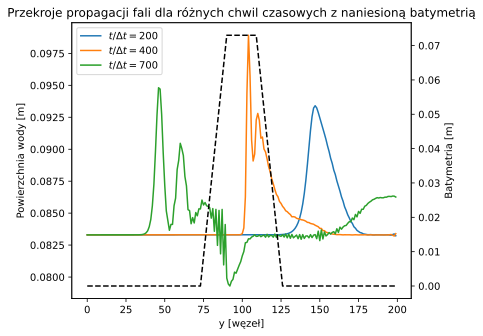

In [ ]:
bathymetry = make_bathymery(grid, h = 0.073)
fig, ax_left = plt.subplots()

ax_left.plot(output_h[200][1, :] + bathymetry[1, :],
             label=r"$t/\Delta t = 200$")
ax_left.plot(output_h[400][1, :] + bathymetry[1, :],
             label=r"$t/\Delta t = 400$")
ax_left.plot(output_h[700][1, :] + bathymetry[1, :],
             label=r"$t/\Delta t = 700$")

ax_left.set_ylabel("Powierzchnia wody [m]")
ax_left.legend(loc="upper left")
ax_left.set_xlabel("y [węzeł]")

ax_right = ax_left.twinx()
ax_right.plot(bathymetry[1, :], "--", color="black", label="bathymetry")
ax_right.set_ylabel("Batymetria [m]")
plt.title("Przekroje propagacji fali dla różnych chwil czasowych z naniesioną batymetrią dla h=0.073m")
plt.tight_layout()
show_plot('przekroj.pdf')
plt.show()


Aby sprawdzić zbieżność wyników symulacji wykonałem symulację dla powiększonej podwójnie siatce i podwójnie pomniejszonego kroku czasowego w obu wymiarach $\frac{\Delta t}{\Delta y}$.

In [ ]:
grid = (12, 400)
hend_2 = np.zeros_like(hs)
for i, h in enumerate(hs):
  hend_2[i], _ = make_sym(grid=grid, h=h, nt = 4800, dt_over_dxy = (0.35, 0.125))

Na poniższym wykresie przedstawiono amplitudę fali przy brzegu w funkcji wysokości przeszkody dla dwóch konfiguracji siatki i różnych wartości parametru $\frac{\Delta t}{\Delta y}$. Obie symulacje wykazują zgodny trend: zwiększenie wysokości przeszkody prowadzi do silniejszego tłumienia fali docierającej do brzegu. Co jest zgodne z intuicją.

Warto jednak zauważyć, że amplitudy otrzymane z obu konfiguracji różnią się o około 10%. Jest to istotna rozbieżność, wskazująca na czułość rozwiązania na wybór parametrów numerycznych i rozdzielczości siatki. Może to wynikać m.in. ze zbieżności numerycznej.

Mimo tych różnic ilościowych, jakościowo obserwujemy, że im większa wysokość przeszkody, tym mniejsza amplituda fali docierającej do brzegu.


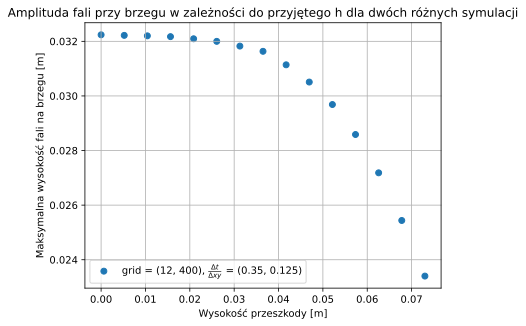

In [ ]:
plt.scatter(hs, hend, label=r"grid = (6, 200), $\frac{\Delta t}{\Delta xy}$ = (0.7, 0.25)")
plt.scatter(hs, hend_2, label=r"grid = (12, 400), $\frac{\Delta t}{\Delta xy}$ = (0.35, 0.125)")
plt.xlabel("Wysokość przeszkody [m]")
plt.ylabel("Maksymalna wysokość fali na brzegu [m]")
plt.title("Amplituda fali przy brzegu w zależności od przyjętego h dla dwóch różnych symulacji")
plt.legend()
plt.grid(True)
show_plot('ampl.pdf')
plt.show()

Aby zrozumieć przyczynę obserwowanych rozbieżności, przeprowadziłem dodatkową serię symulacji, w których zmieniałem jedynie wartość kroku czasowego $\frac{\Delta t}{\Delta y}$. Analizę wykonałem dla przeszkody o wysokości h = 0.01m, czyli w konfiguracji, w której fala praktycznie „nie widzi” zmian batymetrii i nie powinna ulegać istotnemu tłumieniu.

In [ ]:
grid = (6, 200)
k = 6
dtdy = np.zeros(k)
hend001 = np.zeros(k)
for i in range(0, k):
  dy = 0.25/(2**i)
  hend001[i], _ = make_sym(grid=grid, h=0.01, nt = 1000*2**i, dt_over_dxy = (0.7, dy))
  dtdy[i] = dy

Na poniższym wykresie przedstawiona jest zależność amplitudy fali na brzegu od przyjętego kroku czasowego. Wyniki pokazują wyraźną tendencję liniową: amplituda systematycznie rośnie wraz ze zwiększaniem wartości $\frac{\Delta t}{\Delta y}$. Oznacza to, że rozwiązanie nie wykazuje zbieżności numerycznej względem kroku czasowego. W idealnej sytuacji, dla dostatecznie małych wartości $\frac{\Delta t}{\Delta y}$, amplitudy powinny stabilizować się do jednej wartości granicznej. W badanym przypadku tego nie obserwujemy.

Takie zachowanie wskazuje na to, że w badanym przepływie wymagana jest duża rozdaielczość czasowa. Z uwagi na liniowy charakter zależności można wnioskować, że przy $\frac{\Delta t}{\Delta y} → 0$ wynik dążyłby do pewnej wartości granicznej, lecz w praktyce osiągnięcie tego reżimu wymagałoby nienaturalnie małych kroków czasowych, które wydłużyłyby znacząco symulację.

W konsekwencji nie obserwujemy zbieżności w sensie redukcji błędu wraz ze zmniejszaniem kroku czasowego.


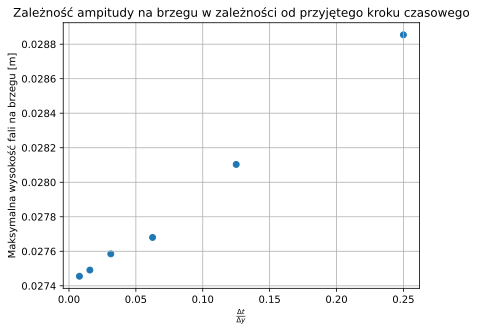

In [ ]:
plt.scatter(dtdy, hend001)
plt.xlabel(r"$\frac{\Delta t}{\Delta y}$")
plt.ylabel("Maksymalna wysokość fali na brzegu [m]")
plt.title("Zależność ampitudy na brzegu w zależności od przyjętego kroku czasowego")
plt.grid(True)
show_plot('dtdy.pdf')
plt.show()

Na koniec przeprowadziłem symulacje jak na rozwiązanie wpływa gęstość siatki wzdłuż osi $y$. Symulacje wykonałem przy zachowaniu stałego stosunku kroku czasowego do przestrzennego $\frac{\Delta t}{\Delta y} = 0.25$. W kolejnych iteracjach podwajałem liczbę węzłów siatki.

In [ ]:
k = 5
ny = np.zeros(k)
hend001_siatka = np.zeros(k)
for i in range(0, k):
  grid = (6, 200*2**i)
  dy = 0.25
  hend001_siatka[i], _ = make_sym(grid=grid, h=0.01, nt = 1000*2**i, dt_over_dxy = (0.7, dy))
  ny[i] = grid[1]

Z poniższego wykresu wynika, że wraz ze zwiększaniem precyzji, uzyskujemy wyższe wartości maksymalnej amplitudy fali na brzegu. Krzywa wzrostu ma charakter asymptotyczny, czyli przyrosty amplitudy maleją wraz z kolejnymi podwojeniami liczby węzłów. Sugeruje to, że dla bardzo gęstych siatek wynik byłby zbieżny do ustalonej wartości fizycznej.

Symulacje prowadziłem do uzyskania siatki o liczbie węzłów grid[1] = 3200. Próba dalszego zagęszczenia siatki dla $k=6$ skutkowała błędem alokacji pamięci (MemoryError), co uniemożliwiło uzyskanie wyniku dla wyższej rozdzielczości.

Uzyskane rezultaty wskazują, że precyzyjne odwzorowanie amplitudy fali w badanym przepływie wymaga stosowania siatek o wysokiej rozdzielczości. Wiąże się to jednak ze znacznym kosztem obliczeniowym i wysokim zapotrzebowaniem na pamięć operacyjną.

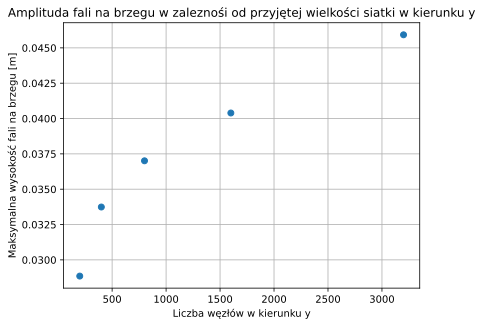

In [ ]:
plt.scatter(ny, hend001_siatka)
plt.xlabel(r"Liczba węzłów w kierunku y")
plt.ylabel("Maksymalna wysokość fali na brzegu [m]")
plt.title("Amplituda fali na brzegu w zaleznośi od przyjętej wielkości siatki w kierunku y")
plt.grid(True)
show_plot('ny.pdf')
plt.show()

### 3. Wnioski

Celem projektu była symulacja tego, jak wysokość trapezoidalnej przeszkody usytuowanej na dnie morskim wpływa na amplitudę fali docierającej do pionowego nabrzeża. Batymetrię układu przygotowałem na podstawie danych z akwarium doświadczalnego JBA Trust.

Jako falę początkową przyjąłem funkcję Gaussa ze środkiem na końcu siatki w kierunku y. Ze względu na to, że przeszkoda była ustawiona wzdłuż osi x, interesowało mnie głównie zachowanie płynu wzdłuż osi y. Dlatego moja podstawowa siatka miała wymiary grid = (6, 200) z krokami $\frac{\Delta t}{\Delta xy} = (0.7, 0.25)$ dla wysokości przeszkody w zakresie od 0 do 0.073 m. Następnie powtórzyłem tę symulację, podwajając dokładność siatki i zmniejszając krok czasowy.

Porównanie tych dwóch symulacji pokazało, że nie są one ze sobą zbieżne. Jednak jakościowo obie symulacje pokazały, że il wyższa przeszkoda tym niższa jest ampituda fali. Następnie przeprowadziłem kolejne testy, aby zbadać zbieżność dla przeszkody o ustalonej wysokości 0.01 m. Najpierw zmieniałem tylko krok czasowy i zauważyłem, że zależność amplitudy fali na brzegu od przyjętego $\Delta t$ jest praktycznie liniowa. Następnie zmieniałem gęstość siatki, gdzie zaobserwowałem, że maksymalna wartość fali rośnie coraz wolniej wraz ze zwiększaniem liczby węzłów.

Uzyskane rezultaty wskazują, że dla tego zagadnienia zarówno krok czasowy, jak i gęstość siatki wymagają dużej dokładności, co w efekcie prowadzi do bardzo dużego zapotrzebowania na pamięć.

Ostatecznie należy też się zastanowić, czy model płytkiej wody na pewno w pełni nadaje się do opisywanego problemu, czy też zjawiska zachodzące na przeszkodzie wymagają bardziej złożonego modelu.